In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet_pretrainer import UnetPretrainer
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_top_k_accuracy
from train_utils import Trainer, he_init

/home/kramasamy/.venv/globalenv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-12-18 19:00:18.990613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734528619.063398    7917 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734528619.083628    7917 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 19:00:19.268714: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

In [2]:
from torchvision.datasets import CIFAR10

# Load config.
with open('../configs/pretrain_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='../../../data/cifar_10', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='.../../../data/cifar_10', train=False, download=True, transform=transform)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

sample_img, label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {label}")

Files already downloaded and verified
Files already downloaded and verified
Train Dataset: 50000 samples
Test Dataset: 10000 samples
Image shape: torch.Size([1, 32, 32])
Label: 6


In [3]:
# Load model.
torch.cuda.empty_cache()
model = UnetPretrainer(config['num_classes'])
model.to('cuda')
model.apply(he_init)
trainer = Trainer(model, train_dataset, config)
result = trainer.train(print_loss=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 2.3980118547167097


  5%|▌         | 1/20 [01:34<30:01, 94.81s/it]

Epoch 2/20, Loss: 2.1067288542280393


 10%|█         | 2/20 [03:14<29:23, 97.96s/it]

Epoch 3/20, Loss: 1.8767788519664688


 15%|█▌        | 3/20 [04:56<28:11, 99.50s/it]

Epoch 4/20, Loss: 1.7612920464301596


 20%|██        | 4/20 [06:42<27:15, 102.21s/it]

Epoch 5/20, Loss: 1.668170701484291


 25%|██▌       | 5/20 [09:05<29:15, 117.03s/it]

Epoch 6/20, Loss: 1.6004839357064695


 30%|███       | 6/20 [11:26<29:10, 125.04s/it]

Epoch 7/20, Loss: 1.4938916588316158


 35%|███▌      | 7/20 [13:46<28:10, 130.06s/it]

Epoch 8/20, Loss: 1.3528603522145017


 40%|████      | 8/20 [16:08<26:43, 133.64s/it]

Epoch 9/20, Loss: 1.279399396205435


 45%|████▌     | 9/20 [18:29<24:54, 135.86s/it]

Epoch 10/20, Loss: 1.2043962989534651


 50%|█████     | 10/20 [20:50<22:54, 137.47s/it]

Epoch 11/20, Loss: 1.1543279095571868


 55%|█████▌    | 11/20 [23:08<20:39, 137.67s/it]

Epoch 12/20, Loss: 1.0857204095441468


 60%|██████    | 12/20 [25:25<18:20, 137.59s/it]

Epoch 13/20, Loss: 1.0146661096689653


 65%|██████▌   | 13/20 [27:42<16:02, 137.45s/it]

Epoch 14/20, Loss: 0.9851621894203887


 70%|███████   | 14/20 [30:00<13:45, 137.63s/it]

Epoch 15/20, Loss: 0.9615168376844756


 75%|███████▌  | 15/20 [32:18<11:28, 137.67s/it]

Epoch 16/20, Loss: 0.9205055413197498


 80%|████████  | 16/20 [34:36<09:11, 137.86s/it]

Epoch 17/20, Loss: 0.9046102695319117


 85%|████████▌ | 17/20 [36:55<06:54, 138.11s/it]

Epoch 18/20, Loss: 0.8892017201501496


 90%|█████████ | 18/20 [39:14<04:36, 138.37s/it]

Epoch 19/20, Loss: 0.8769062240513004


 95%|█████████▌| 19/20 [41:32<02:18, 138.36s/it]

Epoch 20/20, Loss: 0.8735077040536063


100%|██████████| 20/20 [43:51<00:00, 131.58s/it]


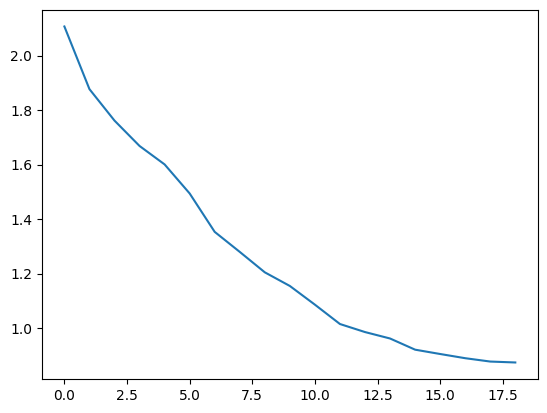

In [4]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [5]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [6]:
print(get_top_k_accuracy(y_pred_train, y_true_train, k = 1))
print(get_top_k_accuracy(y_pred_test, y_true_test, k = 1))


68.80799531936646
66.74000024795532


In [7]:
import pickle as pkl
pkl.dump(result, open('../checkpoints/pretrain_unet_results.pkl', 'wb'))